## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Camera calibration using chessboard images
* Read calibration images of a chessboard
* Creat the same object points (6x9x3) for all images. 
* Find corners for all images and append the point to image points (6x9). 

In [25]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

#parameter
nx = 9 #number of corners in x
ny = 6 #number of corners in y

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((ny*nx,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

fnames = []
img_list = []

# Make a list of calibration images
images = glob.glob('/home/kazuhiro/Dropbox/MyPython/selfdrivingcar/tensorflow/advanced_lane_finding/camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

    # If found, add object points, image points
    if ret == True:
        print(fname)
        fnames.append(fname)
        img_list.append(img)
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)


/home/kazuhiro/Dropbox/MyPython/selfdrivingcar/tensorflow/advanced_lane_finding/camera_cal/calibration11.jpg
/home/kazuhiro/Dropbox/MyPython/selfdrivingcar/tensorflow/advanced_lane_finding/camera_cal/calibration19.jpg
/home/kazuhiro/Dropbox/MyPython/selfdrivingcar/tensorflow/advanced_lane_finding/camera_cal/calibration15.jpg
/home/kazuhiro/Dropbox/MyPython/selfdrivingcar/tensorflow/advanced_lane_finding/camera_cal/calibration3.jpg
/home/kazuhiro/Dropbox/MyPython/selfdrivingcar/tensorflow/advanced_lane_finding/camera_cal/calibration13.jpg
/home/kazuhiro/Dropbox/MyPython/selfdrivingcar/tensorflow/advanced_lane_finding/camera_cal/calibration12.jpg
/home/kazuhiro/Dropbox/MyPython/selfdrivingcar/tensorflow/advanced_lane_finding/camera_cal/calibration9.jpg
/home/kazuhiro/Dropbox/MyPython/selfdrivingcar/tensorflow/advanced_lane_finding/camera_cal/calibration2.jpg
/home/kazuhiro/Dropbox/MyPython/selfdrivingcar/tensorflow/advanced_lane_finding/camera_cal/calibration18.jpg
/home/kazuhiro/Dropbox

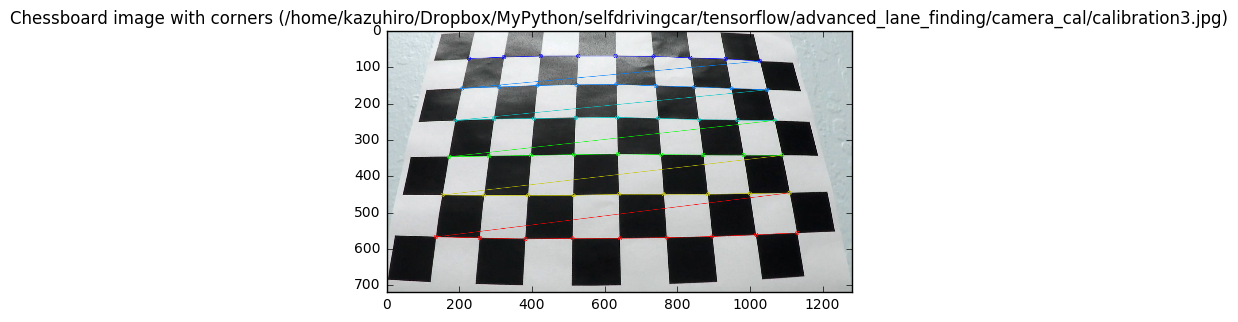

In [26]:
plt.imshow(img_list[3])
plt.title("Chessboard image with corners ("+fnames[3]+")")
plt.show()

## Distortion correction using chessboard images
* Calibrate camera using object and image points to get distortion coefficients (dist ) and camera matrix(mtx).

In [27]:
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist,mtx, dist

idx = 3
img = cv2.imread(fnames[3])
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
undist = cv2.undistort(img, mtx, dist, None, mtx)

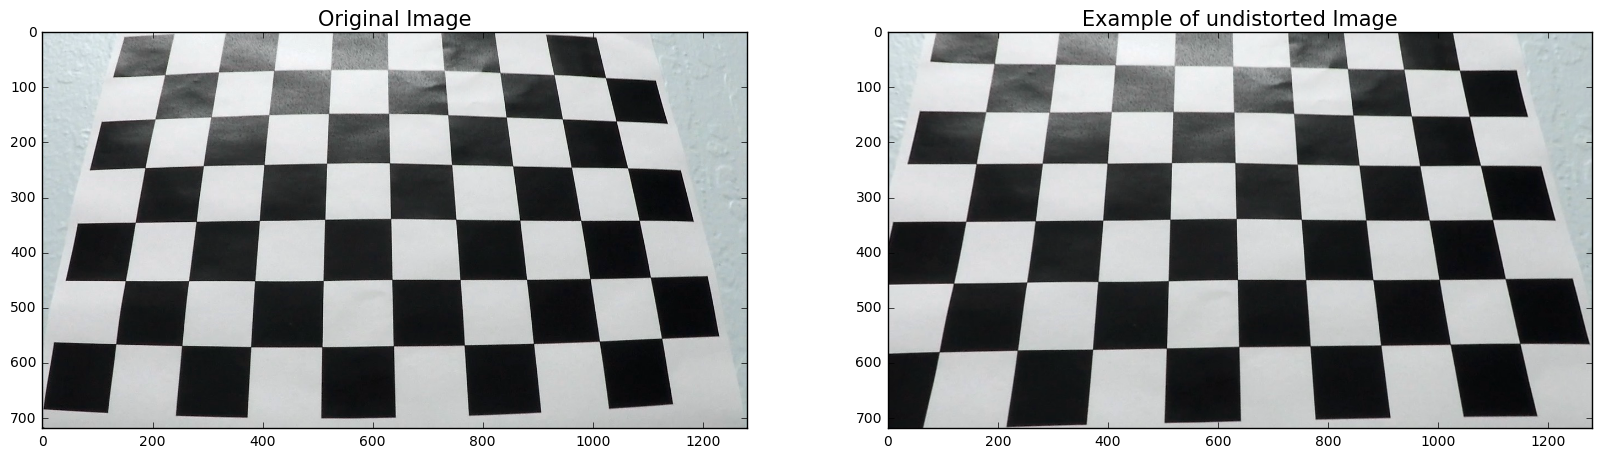

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(undist)
ax2.set_title('Example of undistorted Image', fontsize=15)

## Combine color and gradient threshhold to create the best edge detection
* To detect different colors of lane lines under varying degrees of daylight and shadow.

In [5]:

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    if orient=='x':
        sobelx = cv2.Sobel(gray, cv2.CV_64F,1,0)
        abs_sobel = np.absolute(sobelx)
    else: 
        sobely = cv2.Sobel(gray, cv2.CV_64F,0,1)
        abs_sobel = np.absolute(sobely)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0,1, sobel_kernel)
    sobelxy = np.sqrt(np.square(sobelx)+np.square(sobely))
    abs_sobelxy = np.absolute(sobelxy)
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

def col_threshhold(img, thresh=(0,255)):
    #Convert to HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    #Separate the S channel
    s_channel = hsv[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1
    return s_binary

def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=9, thresh=(10, 255))
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=9, thresh=(60, 255))
    mag_binary = mag_thresh(img, sobel_kernel=9, mag_thresh=(40, 255))
    dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    s_binary = col_threshhold(img, thresh=(170,255))
    combined_binary = np.zeros_like(combined)
    combined_binary[(s_binary ==1) | (combined == 1)] = 1
    return combined_binary

## Result of threshhold binary images of test images
* The output is shown below. The combination of binary thresholding the S channel (HLS) and binary thresholding the result of applying the combining Sobel operator of the x direction, y direction, and gradient direction on the original image. 

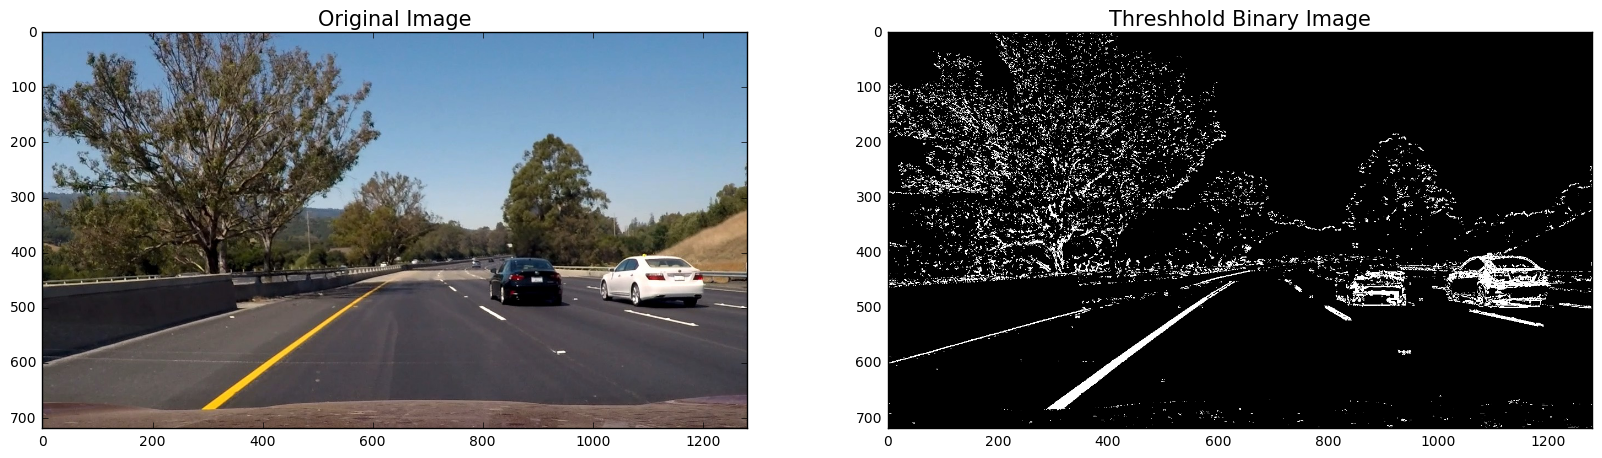

In [6]:
import matplotlib.image as mpimg

test_images = glob.glob('/home/kazuhiro/Dropbox/MyPython/selfdrivingcar/tensorflow/advanced_lane_finding/test_images/test*.jpg')

testimg = test_images[0]

img_before = mpimg.imread(testimg)
img_after = pipeline(img_before)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img_before)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(img_after,cmap='gray')
ax2.set_title('Threshhold Binary Image', fontsize=15)
plt.show()

## Unwarp function
* Create a top down view
    * Correct distortion with distortion coefficients and camera matrix that I made with a chessboard.
    * Transform perspective using source and destination points to get Transformation Matrix. Source points are manually restricted in rectangle area.  
    * Warp the image to top down view with the value M, Transformation Matrix. 

In [9]:
def unwarp(img, nx, ny, mtx, dist, offset=100):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    imshape = img.shape
    img_size = (imshape[1], imshape[0])
    area = [[150+430,460],[1150-440,460],[1150,720],[150,720]]
    src = np.float32(area)
    dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    topdown = cv2.warpPerspective(undist, M, img_size)
    return topdown, M, Minv

## Example of warped image on straight road 

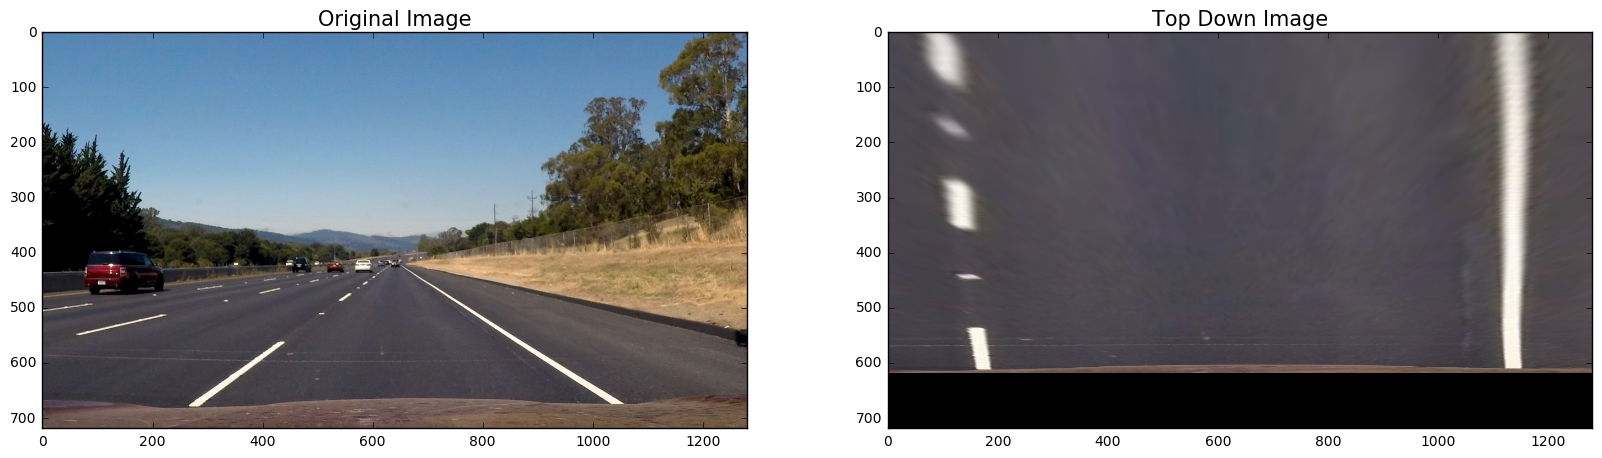

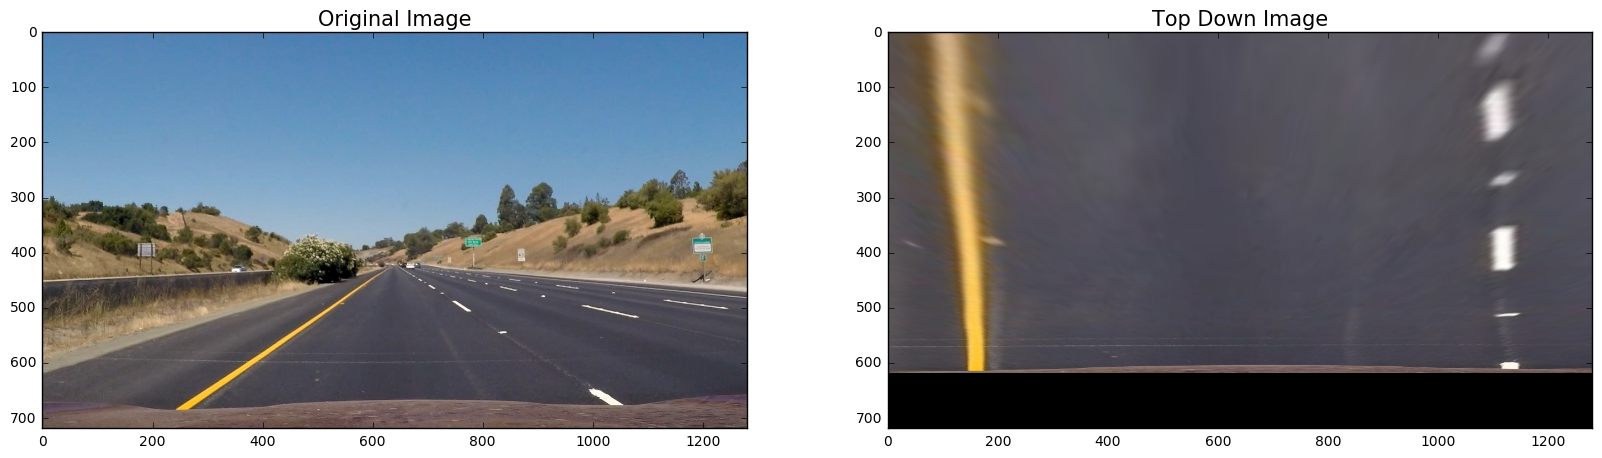

In [10]:
straight_test_images = glob.glob('/home/kazuhiro/Dropbox/MyPython/selfdrivingcar/tensorflow/advanced_lane_finding/test_images/straight_lines*.jpg')

for i in range(len(straight_test_images)):
   testimg = straight_test_images[i]
   img = mpimg.imread(testimg)
   topdown, M,Minv = unwarp(img, nx, ny, mtx,dist)

   f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
   ax1.imshow(img)
   ax1.set_title('Original Image', fontsize=15)
   ax2.imshow(topdown)
   ax2.set_title('Top Down Image', fontsize=15)
   plt.show()

## Example of warped image on curved road
* Create top down view from the original image
* With top down view we can find the peak in the columns and lanes on left and right using histgram.  

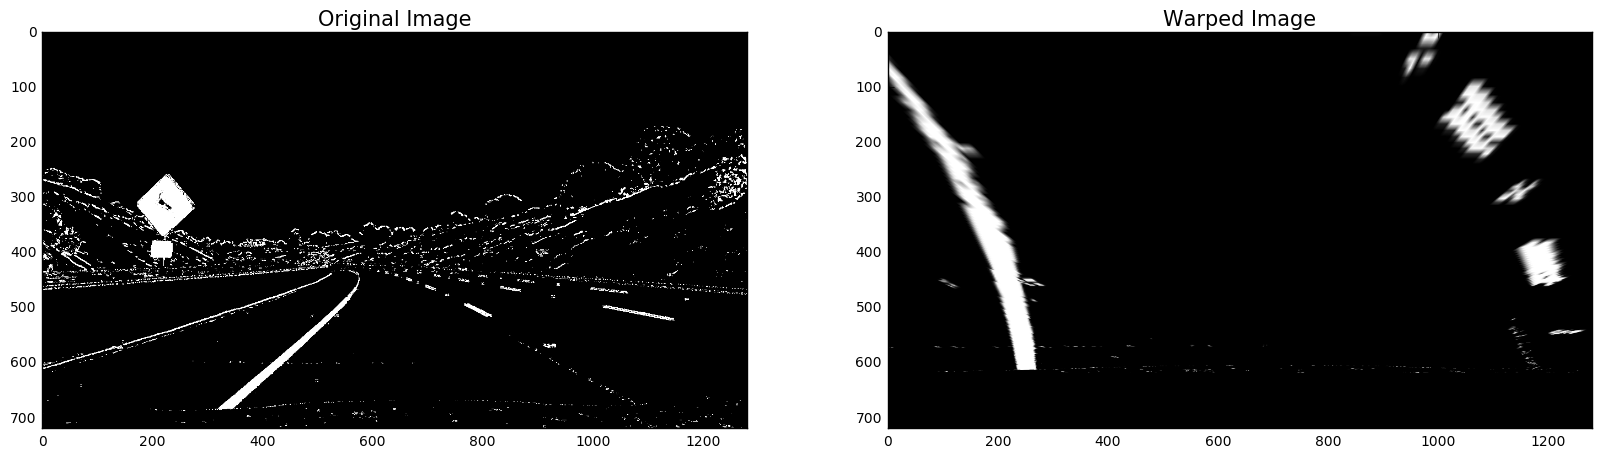

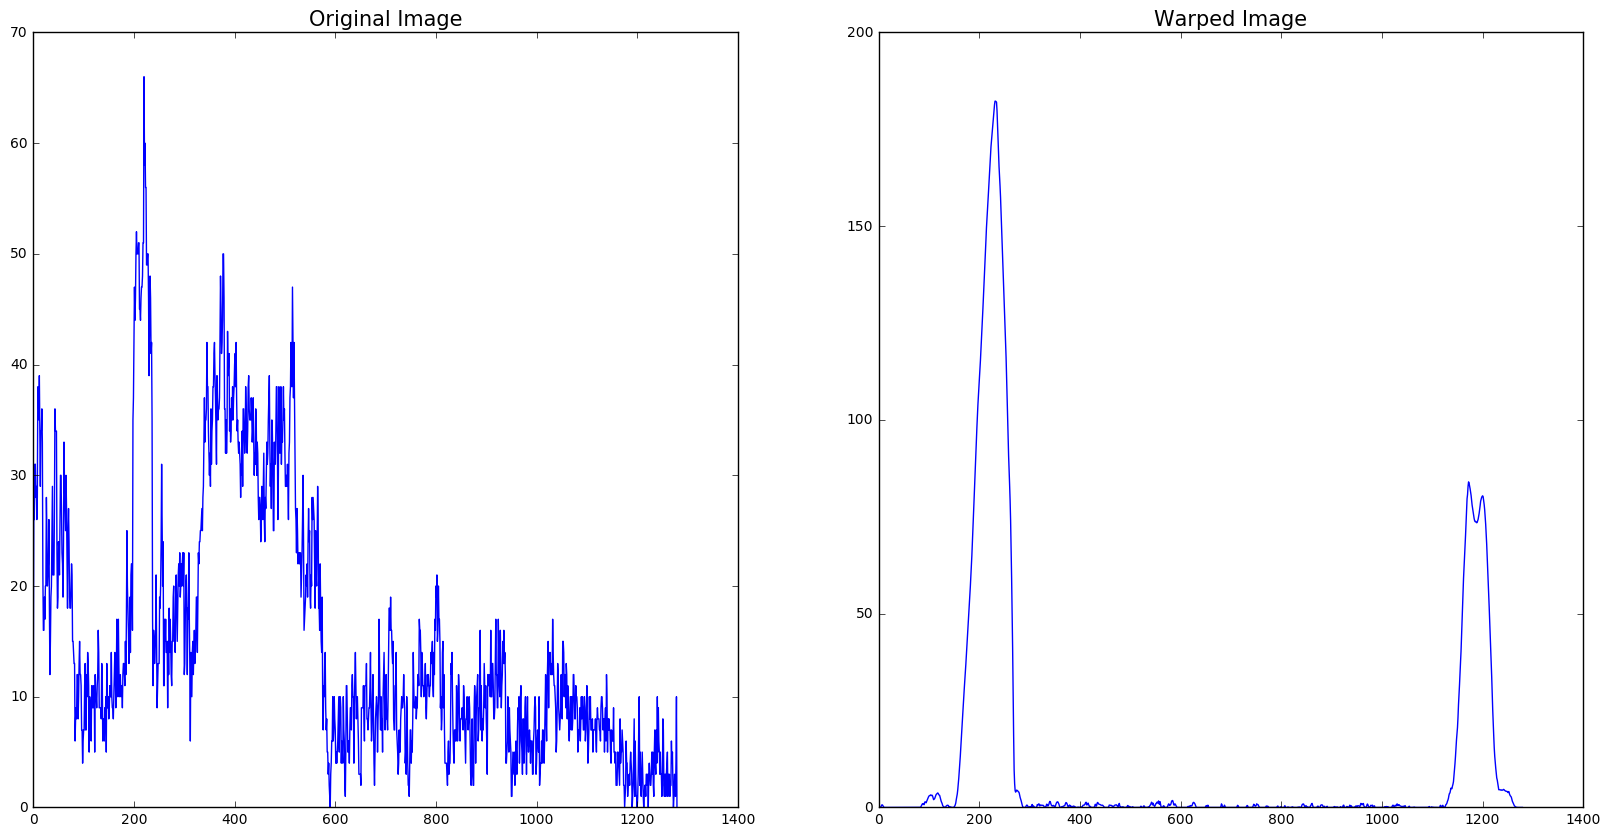

In [11]:
testimg = test_images[2]
img = mpimg.imread(testimg)
color_binary = pipeline(img)
imshape = color_binary.shape

topdown, M, Minv = unwarp(color_binary,nx, ny, mtx,dist)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(color_binary,cmap='gray')
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(topdown,cmap='gray')
ax2.set_title('Warped Image', fontsize=15)
plt.show()

hist1 = np.sum(color_binary[360:,:], axis=0)
hist2 = np.sum(topdown[360:,:], axis=0)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.plot(hist1)
ax1.set_title('Original Image', fontsize=15)
ax2.plot(hist2)
ax2.set_title('Warped Image', fontsize=15)
plt.show()




## Finding the lanes
* Implement sliding windows for finding hot pixels and eventualy the line robustly.
* Fit a polynomial
    * Use x and y pixel positions to fit a second polynomial curve (f(y)=Ay^2+By+C)
* Visualize fit line
* Measure the curvature and distance from center
    * Radius of curvature at any point x using formula [Tutorial](http://www.intmath.com/applications-differentiation/8-radius-curvature.php)
* Draw the lane area back onto the original image
    * Warp the top down view to the original image using inverse perspective matrix (Minv)

In [12]:
def find_curvature(yvals, fitx):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(yvals)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    fit_cr = np.polyfit(yvals*ym_per_pix, fitx*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*fit_cr[0])
    return curverad

def find_position(pts):
    # Find the position of the car from the center
    # It will show if the car is 'x' meters from the left or right
    image_shape = (720, 1280, 3)
    position = image_shape[1]/2
    left  = np.min(pts[(pts[:,1] < position) & (pts[:,0] > 700)][:,1])
    right = np.max(pts[(pts[:,1] > position) & (pts[:,0] > 700)][:,1])
    center = (left + right)/2
    # Define conversions in x and y from pixels space to meters
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension    
    return (position - center)*xm_per_pix


def linefit(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]/2.:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2.)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    curvature  = find_curvature(ploty, left_fitx)
    
    return left_fitx, right_fitx, ploty, curvature

def draw_lanearea(img,topdown,left_fitx,right_fitx,ploty,Minv,curvature):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(topdown).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result_img = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    
    # Put text for curvature
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Radius of Curvature: {} m".format(int(curvature))
    cv2.putText(result_img,text,(400,100), font, 1,(255,255,255),2)
    
    # Find the position of the car relative to center
    pts = np.argwhere(newwarp[:,:,1])
    position = find_position(pts)
    
    if position < 0:
        text = "Vehicle is {:.2f} m left of center".format(-position)
    else:
        text = "Vehicle is {:.2f} m right of center".format(position)
    cv2.putText(result_img,text,(400,150), font, 1,(255,255,255),2)
    
    return result_img

/home/kazuhiro/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:28: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


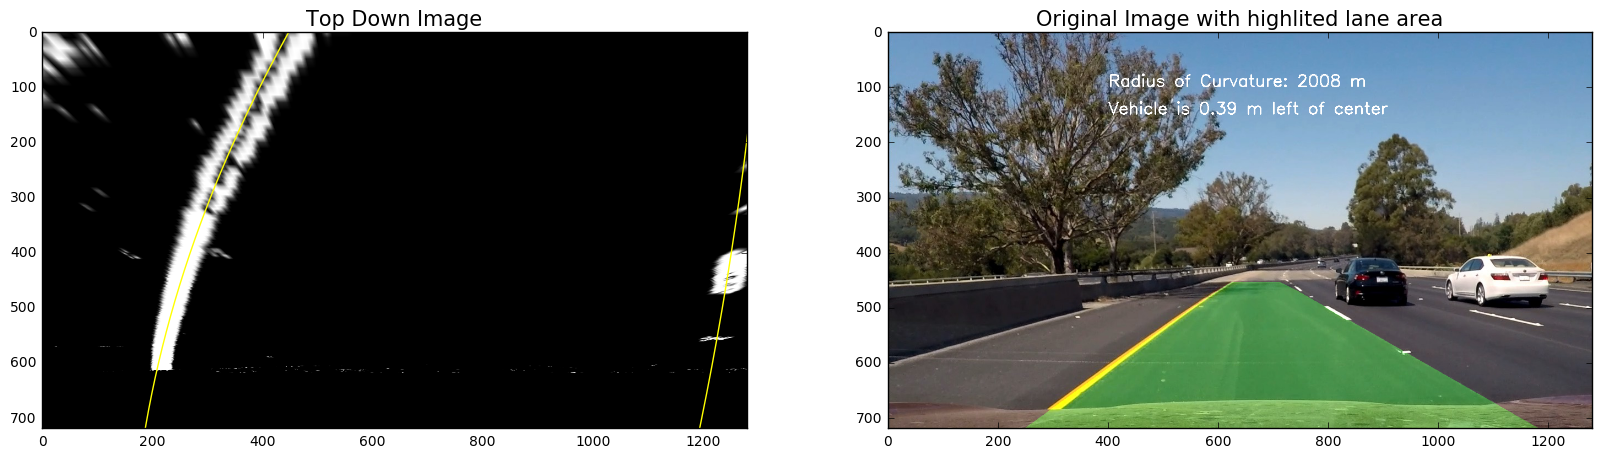

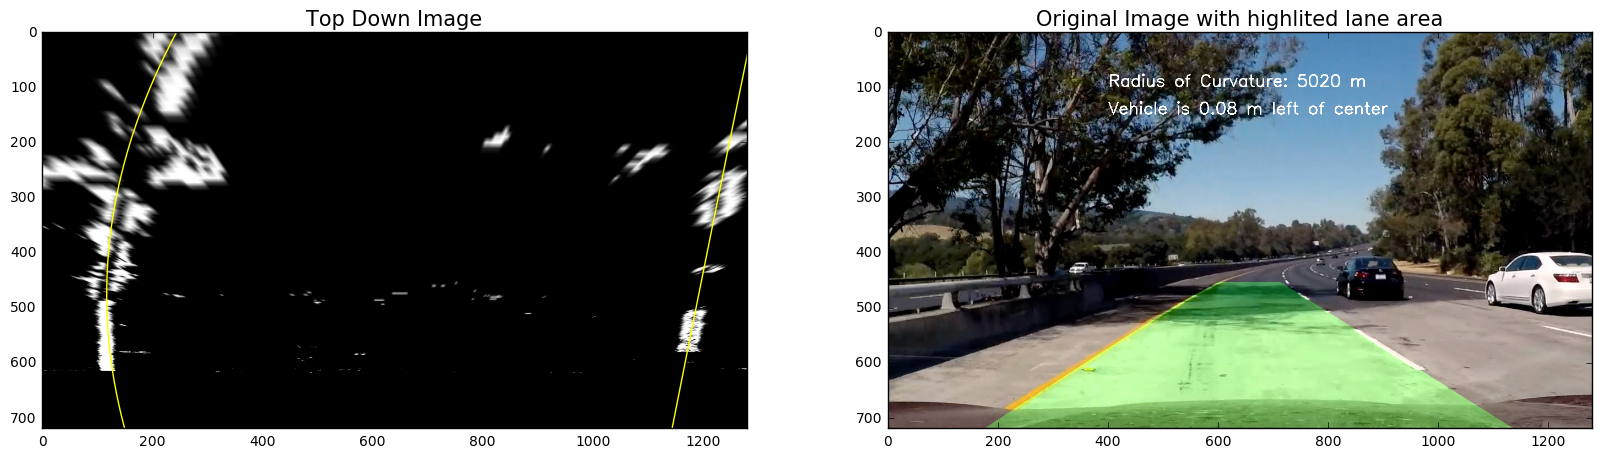

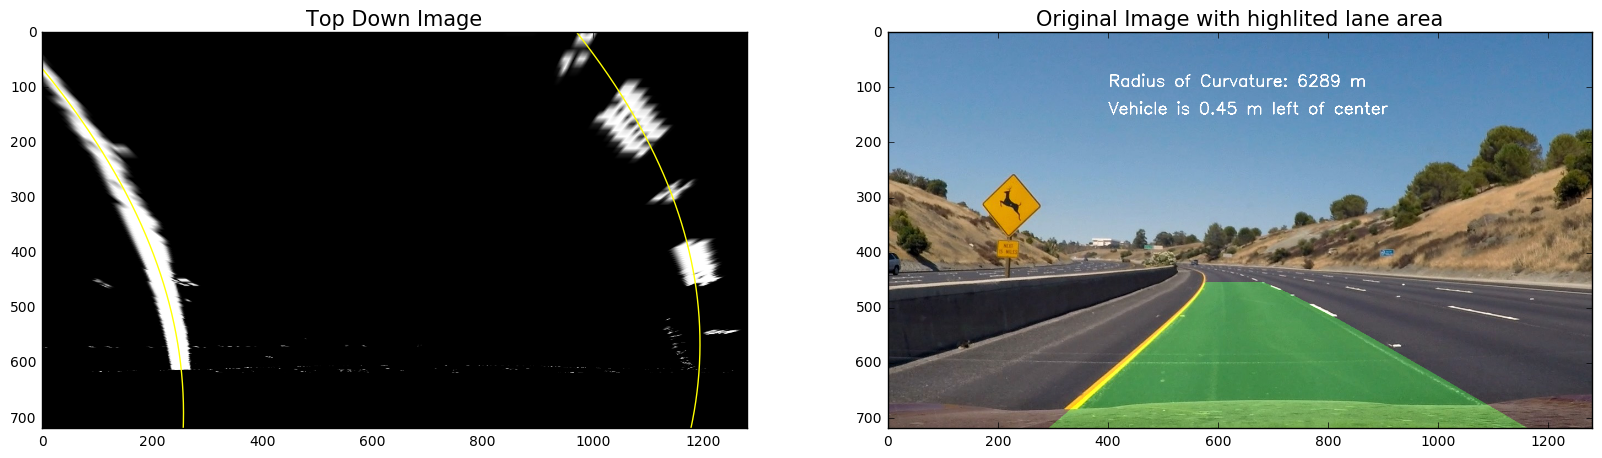

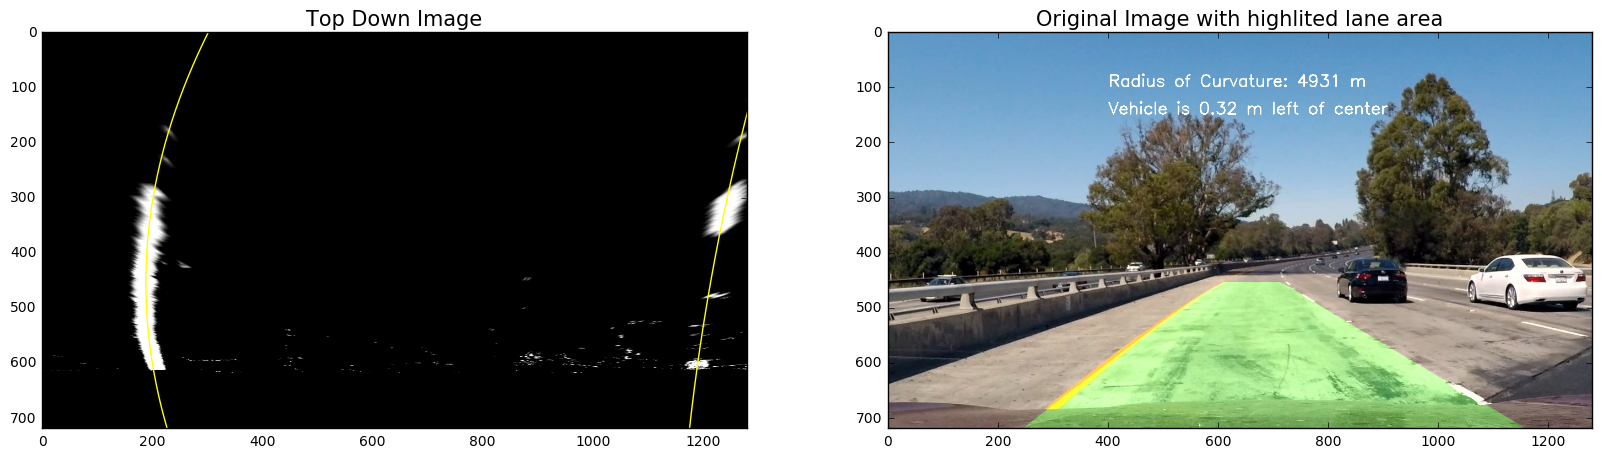

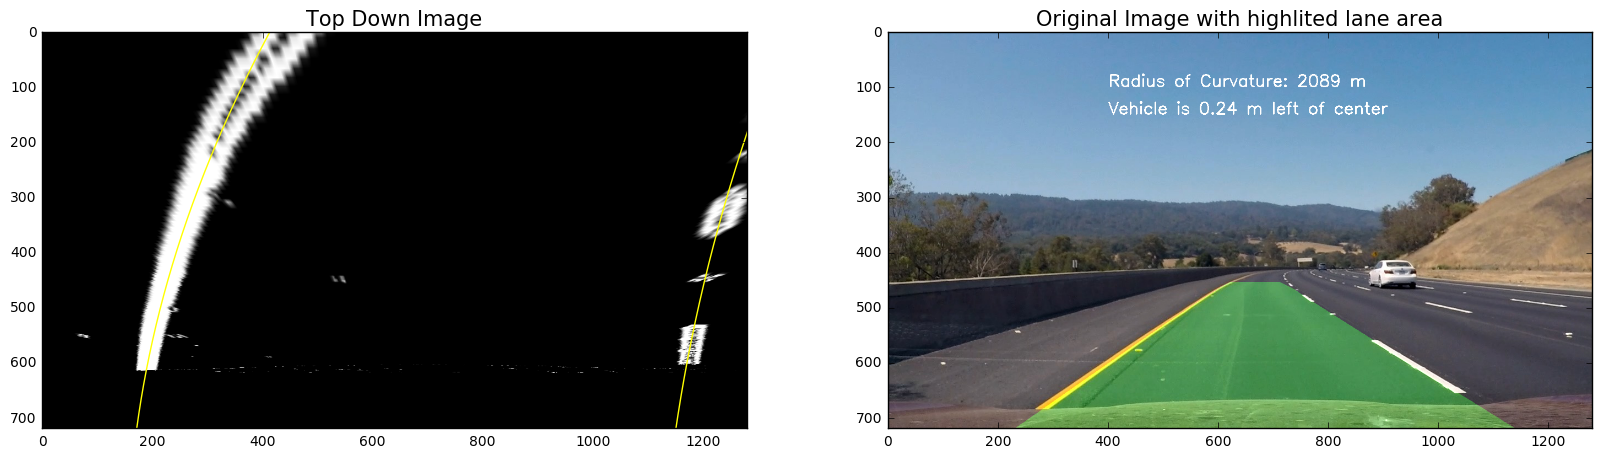

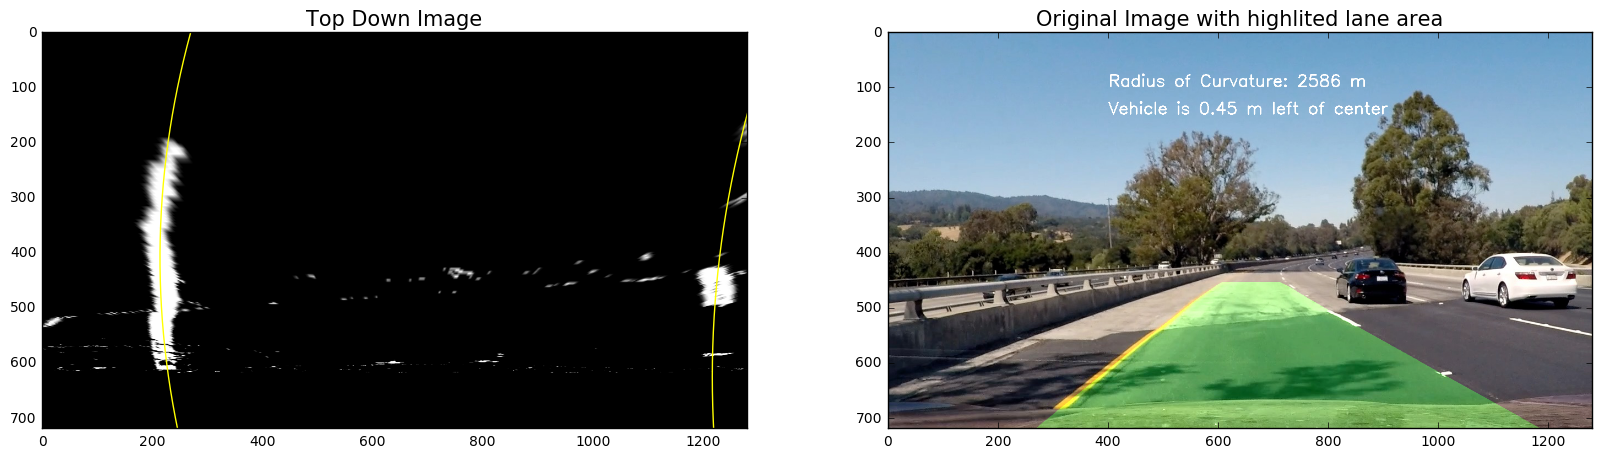

In [13]:
for testimg in test_images:
    img = mpimg.imread(testimg)
    color_binary = pipeline(img)
    topdown, M, Minv = unwarp(color_binary,nx, ny, mtx,dist)
    left_fitx, right_fitx, ploty, curvature = linefit(topdown)
    result_img = draw_lanearea(img,topdown,left_fitx,right_fitx,ploty,Minv,curvature)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.plot(left_fitx, ploty, color='yellow')
    ax1.plot(right_fitx, ploty, color='yellow')
    ax1.imshow(topdown,cmap='gray')

    ax1.set_title('Top Down Image', fontsize=15)
    ax2.set_title('Original Image with highlited lane area', fontsize=15)
    ax2.imshow(result_img)
    plt.show()

## Video
  * Process image for sample video

In [21]:
def process_image(img):
    color_binary = pipeline(img)
    topd_fitx, right_fitx, ploty, curvature = linefit(topdown)
    result_img = draw_lanearea(img,topdown,left_fitx,right_fitx,ploty,Minv,curvature)
    return result_img

In [22]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [23]:
white_output = 'white.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 1260/1261 [20:03<00:00,  1.11it/s]    | 1/1261 [00:00<11:29,  1.83it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 54min 46s, sys: 2min 50s, total: 57min 36s
Wall time: 20min 8s
